In [1]:
# coding: utf-8
import gym
import torch.utils.data as data
from dynamics import *
from controller import *
from utils import *
from quanser_robots.common import GentlyTerminating
import time

# datasets:  numpy array, size:[sample number, input dimension]
# labels:  numpy array, size:[sample number, output dimension]

env_id ="Qube-v0" # "CartPole-v0"
env = GentlyTerminating(gym.make(env_id))
config_path = "config.yml"
config = load_config(config_path)
print_config(config_path)

************************
*** model configuration ***
load_model: false
model_path: storage/exp_7.ckpt
n_actions: 1
n_hidden: 2
n_states: 6
size_hidden: 128
use_cuda: true

*** train configuration ***
batch_size: 64
exp_number: 7
learning_rate: 0.0006
n_epochs: 1000
save_loss_fig: true
save_loss_fig_frequency: 100
save_model_flag: true
save_model_path: storage/exp_7.ckpt

************************
*** dataset configuration ***
load_flag: false
load_path: storage/data_exp_7.pkl
min_train_samples: 6000
mpc_dataset_split: 0.5
n_max_steps: 500
n_mpc_episodes: 8
n_mpc_itrs: 100
n_random_episodes: 30
save_flag: true
save_path: storage/data_exp_7.pkl
testset_split: 0.2

************************
*** MPC controller configuration ***
action_high: 5
action_low: -5
gamma: 0.8
horizon: 20
max_itrs: 40
numb_bees: 8



In [2]:
config["dataset_config"]["load_flag"] = True
config["dataset_config"]["load_path"] = "storage/data_exp_1.pkl"
config["model_config"]["load_model"] = True
config["model_config"]["model_path"] = "storage/exp_1.ckpt"
model = DynamicModel(config)
data_fac = DatasetFactory(env,config)
#data_fac.collect_random_dataset()

Load datas from storage/data_exp_1.pkl


In [3]:
dataset_norm=model.norm_train_data(data_fac.all_dataset["data"],data_fac.all_dataset["label"])

/home/xinye/projects/rl/RL-project/MPC/MPC qube/dynamics.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda()


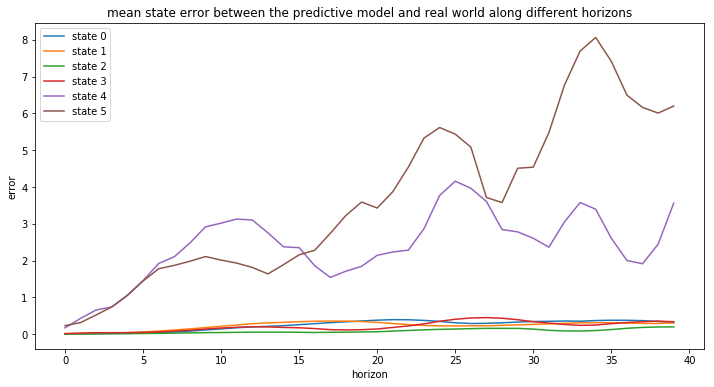

In [4]:
model.plot_model_validation(env,horizon=40,n_sample=20,mpc=[],mode="mean")

/home/xinye/projects/rl/RL-project/MPC/MPC qube/dynamics.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda()


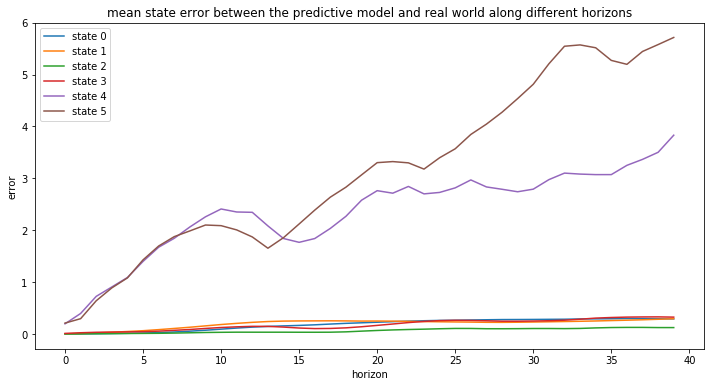

In [5]:
model.plot_model_validation(env,horizon=40,n_sample=200,mpc=[],mode="mean")

/home/xinye/projects/rl/RL-project/MPC/MPC qube/dynamics.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda()


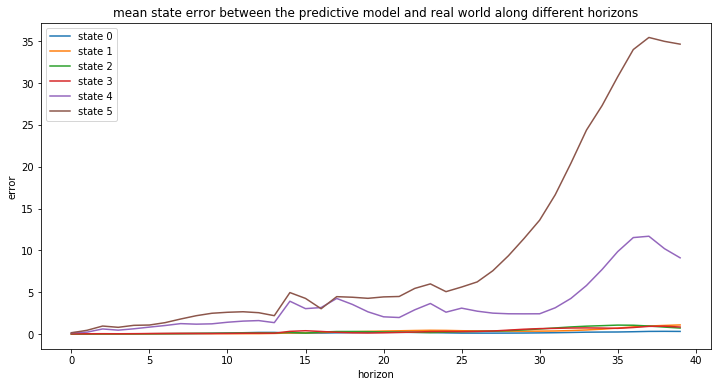

In [7]:
config["mpc_config"]["horizon"] = 20
config["mpc_config"]["numb_bees"] = 8
config["mpc_config"]["max_itrs"] = 20
config["mpc_config"]["gamma"] = 0.98
mpc = MPC(env,config)
errors = model.model_validation(env,horizon=40,n_sample=20,mpc=mpc)

/home/xinye/projects/rl/RL-project/MPC/MPC qube/dynamics.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda()


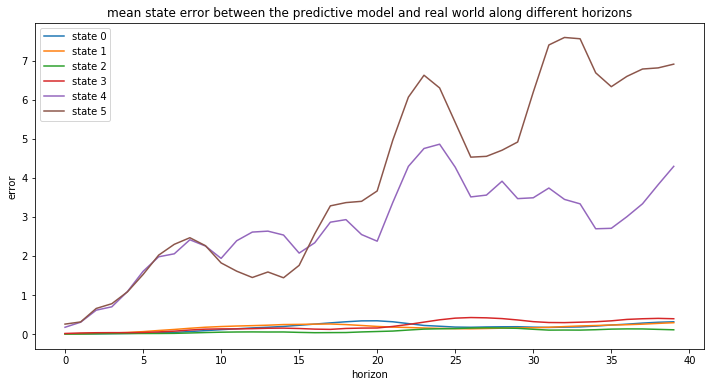

In [8]:
model.plot_model_validation(env,horizon=40,n_sample=20,mpc=[],mode="mean")

In [ ]:
loss = model.train(data_fac.random_trainset,data_fac.random_testset)

In [ ]:
config["mpc_config"]["horizon"] = 12
config["mpc_config"]["numb_bees"] = 8
config["mpc_config"]["max_itrs"] = 20
config["mpc_config"]["gamma"] = 0.98
mpc = MPC(env,config)

In [ ]:
rewards_list = []
for itr in range(config["dataset_config"]["n_mpc_itrs"]):
    t = time.time()
    print("**********************************************")
    print("The reinforce process [%s], collecting data ..." % itr)
    rewards = data_fac.collect_mpc_dataset(mpc,model)
    trainset, testset = data_fac.make_dataset()
    rewards_list += rewards
    
    plt.close("all")
    plt.figure(figsize=(12, 5))
    plt.title('Reward Trend with %s iteration' % itr)
    plt.plot(rewards_list)
    plt.savefig("storage/reward-" + str(model.exp_number) + ".png")
    print("Consume %s s in this iteration" % (time.time()-t))
    loss = model.train(trainset,testset)